In [70]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import matplotlib.image as mpimg
import pycolmap
from pathlib import Path
from src.geometry.point_transformation import *

### Gaussian Function
Gaussian is defined by a mean $\mu$ and, in case of 2D, by 2x2 covariance matrix 

In [71]:
white_data = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=1000)

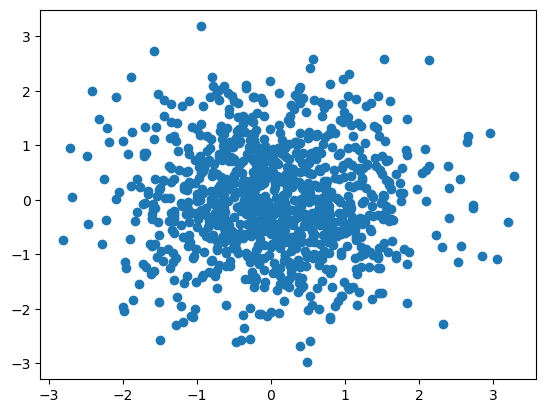

In [72]:
plt.scatter(white_data[:, 0], white_data[:, 1])

For eigenvectors and eigenvalues of a matrix $A$ it is true that 

$$A v = \lambda v$$

where $v$ is an eigenvector and $\lambda$ is a corresponding eigenvalue

In [73]:
cov = [[3, 2], [2, 3]]
eigenvalues, eigenvectors = np.linalg.eig(cov)

v = eigenvectors[:, 0]
lambd = eigenvalues[0]

lhs = cov @ v 
rhs = lambd * v

print(f"LHS = {lhs}")
print(f"RHS = {rhs}")
print(np.allclose(lhs, rhs))

LHS = [3.53553391 3.53553391]
RHS = [3.53553391 3.53553391]
True


If we have white data $D$ defined as above, then we can apply a transformation $T$ consisting of rotation $R$ and scaling $S$ ($T = RS$) to get new data $D'$. It relates covariance matrix as follows $$\Sigma = TIT^{T}$$ $$\Sigma = RS(RS)^{T}$$ $$\Sigma = RSS^TR^T$$

How does it relate to eigenvalues & eigenvectors?

$$\Sigma V = V L$$ where $V$ is a matrix of eigenvectors and $L$ is a diagonal matrix of eigenvalues

$$\Sigma = V L V^{-1}$$

It is the eigendecomposition of the covariance matrix, where $R = V$ and $S = \sqrt{L}$

In [74]:
cov = [[3, 2], [2, 3]]
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [75]:
eigenvalues

array([5., 1.])

In [76]:
eigenvectors

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [77]:
R = eigenvectors
S = np.sqrt(np.diag(eigenvalues))
print(R)
print(S)
new_cov = R @ S @ S.T @ R.T
print(new_cov)
np.allclose(new_cov, cov) # same as original one

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[[2.23606798 0.        ]
 [0.         1.        ]]
[[3. 2.]
 [2. 3.]]


True

In [78]:
U, M, V = LA.svd(cov)
M = np.sqrt(np.diag(M))

In [79]:
print(U)
print(M)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[[2.23606798 0.        ]
 [0.         1.        ]]


In [80]:
np.allclose(new_cov, cov) # same as original one

True

In [81]:
transformed_data = white_data @ S @ R.T

In [82]:
transformed_data

array([[ 1.74842701,  1.18657372],
       [-1.27260285, -3.05396164],
       [-0.63830974, -0.20771006],
       ...,
       [ 0.2812958 , -0.5276534 ],
       [ 2.33611656,  3.01622959],
       [-0.1072901 , -1.82986308]])

In [83]:
data = np.random.multivariate_normal(mean=[0, 0], cov=cov, size=1000)

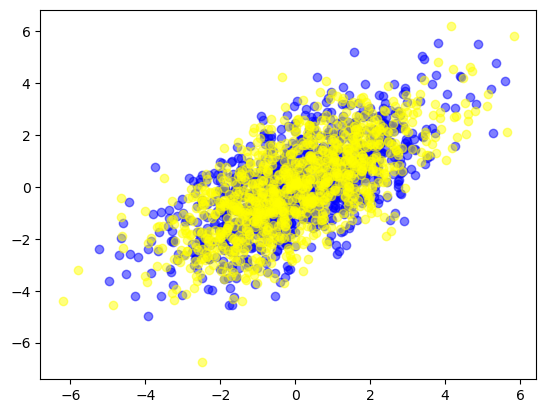

In [84]:
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5, color='blue')
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='yellow')

### Projecting 3D Covariance onto 2D 

In general, if we want to apply $V$ transformation to a covariance matrix $\Sigma$, then 

$$\Sigma' = V \Sigma V^{T}$$

In [85]:
scene_folder = Path('../data/south-building')
images_folder = scene_folder / 'images'
database_path = scene_folder / 'database.db'

reconstruction = pycolmap.Reconstruction(scene_folder / '0')
camera = reconstruction.cameras[1]
img_id = 60
img = reconstruction.images[img_id]
img_name = img.name

In [86]:
width, height = camera.width, camera.height

In [87]:
img_points, colors = projection_from_reconstruction(reconstruction, img_id)
points, colors = filter_view_points(img_points, colors, width, height)

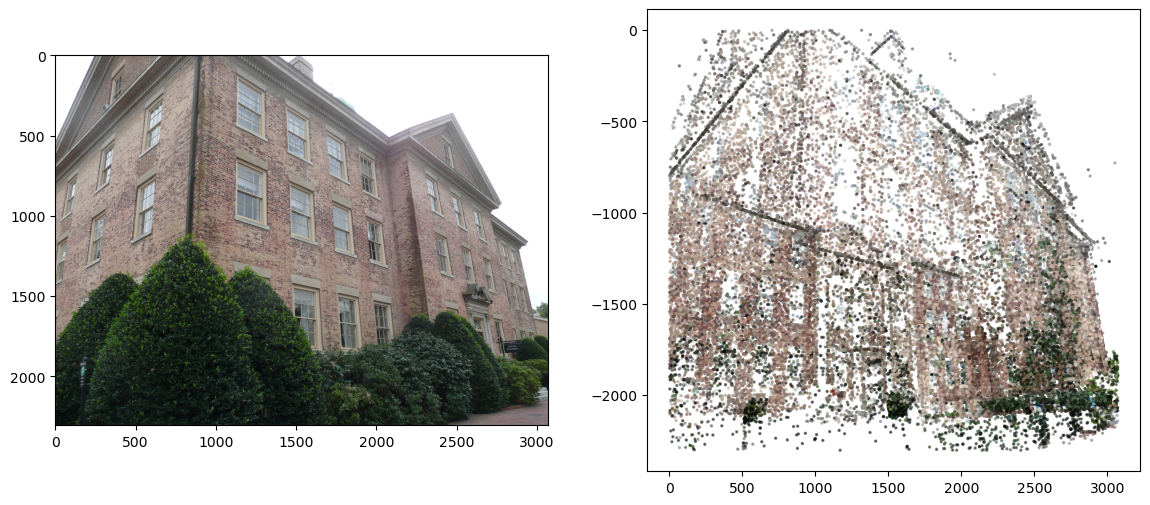

In [88]:
image = mpimg.imread(images_folder / f'{img_name}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.scatter(points[:, 0], -points[:, 1], alpha=0.5, c=colors, s=2)

In [89]:
extrinsic_params = get_extrinsic_params(get_camera_from_image(img))
print(extrinsic_params)

[[ 0.65883531 -0.16565849 -0.73382103  1.29975755]
 [ 0.21772808  0.97569481 -0.02478149  1.12463341]
 [ 0.72009063 -0.14344652  0.6788907   3.4804925 ]
 [ 0.          0.          0.          1.        ]]


In [90]:
viewing_transformation = extrinsic_params[:3, :3] # LA.inv(extrinsic_params[:3, :3])
viewing_transformation

array([[ 0.65883531, -0.16565849, -0.73382103],
       [ 0.21772808,  0.97569481, -0.02478149],
       [ 0.72009063, -0.14344652,  0.6788907 ]])

In [91]:
cov3D = np.array([[1, 2, 3], [2, 3, 2], [1, 1, 1]])

Viewing transformation is used to transform from object space to camera coordinates

In [92]:
variance_in_camera_coordinates = viewing_transformation @ cov3D @ viewing_transformation.T
variance_in_camera_coordinates

array([[-0.95085894, -0.02628593,  0.31368265],
       [-1.03326961,  3.65958533,  2.81672352],
       [-1.41997889,  1.82657123,  2.29127361]])

### Perspective Projection

In perspective projection, a 3D point in a truncated pyramid frustum (eye coordinates) is mapped to a cube (NDC).

<div>
<img src="images/gl_projectionmatrix01.png" width="500">
</div>

A 3D point is projected onto **near** plane in eye space (2D). The following show how point $(x_e, y_e, z_e)$ is projected to $(x_p, y_p, z_p)$ on the near space.

<div>
<img src="images/gl_projectionmatrix03.png" width="500">
<img src="images/gl_projectionmatrix04.png" width="500">
</div>

Using the ratio of similar triangles, we calculate:

$$x_p = \frac{n * x_e}{-z_e}$$
$$y_p = \frac{n * y_e}{-z_e}$$
$$z_p = -n$$

However, this transformation can't be represented by 3x3 matrix so we'll need to use it's approximation. We'll need to find Jacobian matrix 

$$ J = \begin{pmatrix}
 \frac{x_p}{x_e} & \frac{y_p}{x_e} & \frac{z_p}{x_e} \\
 \frac{x_p}{y_e} & \frac{y_p}{y_e} & \frac{z_p}{y_e} \\
 \frac{x_p}{z_e} & \frac{y_p}{z_e} & \frac{z_p}{z_e} 
 \end{pmatrix}
 $$
 
$$J = \begin{pmatrix} 
\frac{-n}{z_e} & 0 & 0 \\
0 & -\frac{n}{z_e} & 0 \\
\frac{nx_e}{z_e^{2}} & \frac{ny_e}{z_e^{2}} & 0
\end{pmatrix}$$

In [93]:
def get_jacobian_matrix(point: np.array, znear):
    J = np.zeros((3, 3))
    J[0, 0] = -znear / point[2]
    J[1, 1] = -znear / point[2]
    J[2, 0] = point[0] / point[2] ** 2
    J[2, 1] = point[1] / point[2] ** 2
    return J 

In [94]:
homogenous_points = convert_to_homogenous(get_points_xyz(reconstruction)).T
projected_to_camera_viewpoint = (extrinsic_params @ homogenous_points).T

In [95]:
jac = get_jacobian_matrix(projected_to_camera_viewpoint[0, :3], 0.1)

In [96]:
jac

array([[-0.03228303,  0.        ,  0.        ],
       [ 0.        , -0.03228303,  0.        ],
       [ 0.15443729,  0.05212275,  0.        ]])

In [97]:
cov = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [98]:
projected_cov = jac @ viewing_transformation @ cov @ viewing_transformation.T @ jac.T

In [99]:
projected_cov[:2, :2]

array([[ 1.04219393e-03, -8.88164124e-21],
       [-1.11214764e-20,  1.04219393e-03]])

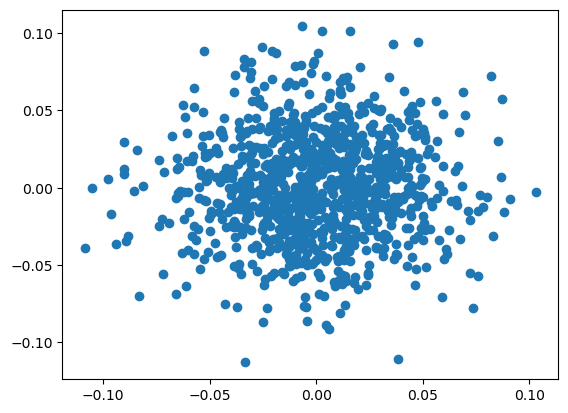

In [100]:
data = np.random.multivariate_normal(mean=[0, 0], cov=projected_cov[:2, :2], size=1000)
plt.scatter(data[:, 0], data[:, 1])

In [105]:
eigenvalues, eigenvectors = LA.eig(projected_cov[:2, :2])

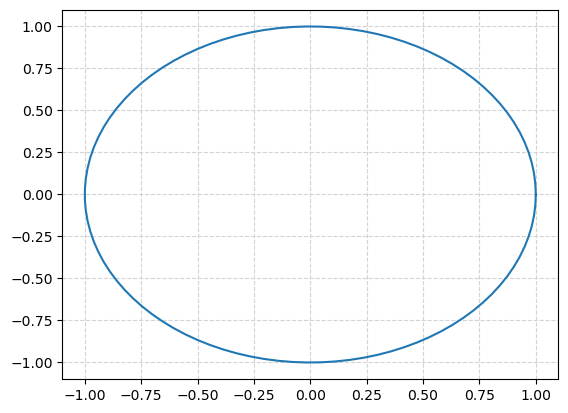

In [106]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi

u=0     #x-position of the center
v=0    #y-position of the center
a=1     #radius on the x-axis
b=1    #radius on the y-axis



t = np.linspace(0, 2*pi, 100)

plt.plot( u+a*np.cos(t) , v+b*np.sin(t) )
plt.grid(color='lightgray',linestyle='--')
plt.show()

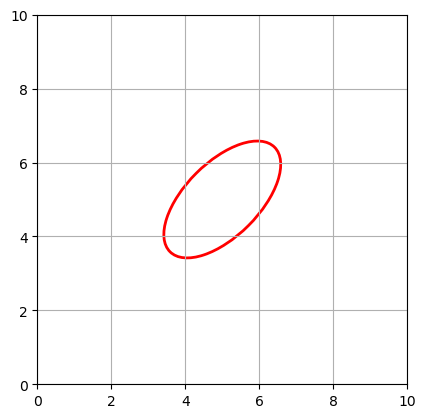

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

# Function to plot an ellipse
def plot_ellipse(ax, center, width, height, angle):
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, edgecolor='r', fc='None', lw=2)
    ax.add_patch(ellipse)

# Sample data
center = (5, 5)
width = 4
height = 2
angle = 45

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
plot_ellipse(ax, center, width, height, angle)

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
plt.grid(True)
plt.show()

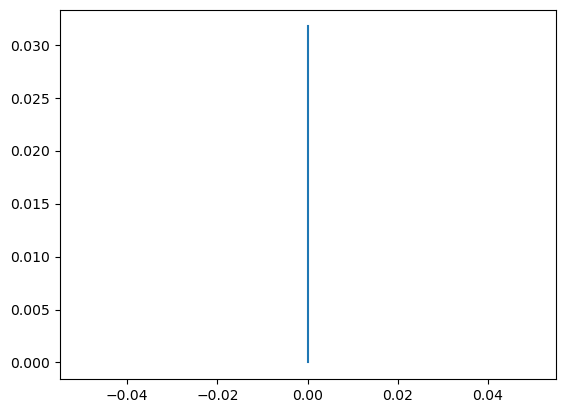

In [111]:
eigvals, eigvecs = np.linalg.eigh(projected_cov[:2, :2])

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))

sphere_points = np.stack((x, y), axis=0).reshape(2, -1)
ellipsoid_points = eigvecs @ np.diag(np.sqrt(eigvals)) @ sphere_points
plt.plot(sphere_points[:, 0], sphere_points[:, 1])

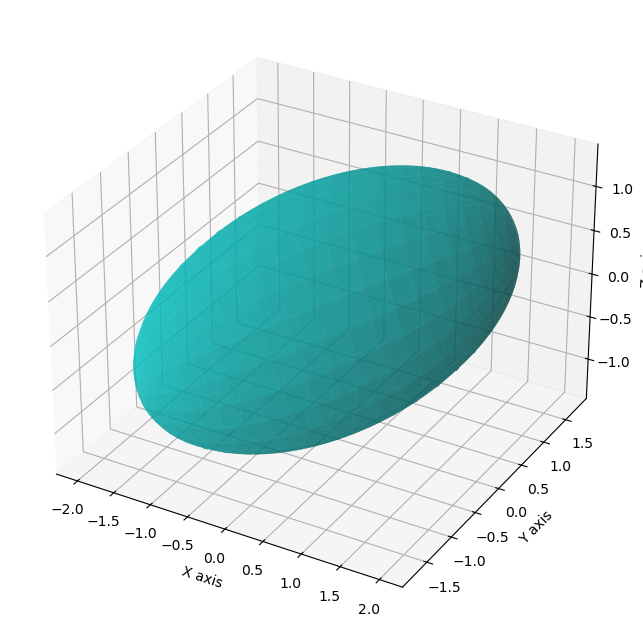

In [114]:
# Generated by chatgpt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import sqrtm

# Step 1: Define the 3D covariance matrix (symmetric 3x3 matrix)
covariance_matrix = np.array([[4, 1, 1],
                              [1, 3, 0.5],
                              [1, 0.5, 2]])

# Step 2: Compute eigenvalues and eigenvectors of the covariance matrix
eigvals, eigvecs = np.linalg.eigh(covariance_matrix)

# Step 3: Generate a sphere
# Create a grid of points that forms a unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Stack the sphere points into a 3xN array (for matrix multiplication)
sphere_points = np.stack((x, y, z), axis=0).reshape(3, -1)

# Step 4: Transform the unit sphere into the ellipsoid using the covariance matrix
# Scale the sphere points by the eigenvalues and rotate them using the eigenvectors
ellipsoid_points = eigvecs @ np.diag(np.sqrt(eigvals)) @ sphere_points

# Reshape to 3D for plotting
x_ellipsoid = ellipsoid_points[0, :].reshape(100, 100)
y_ellipsoid = ellipsoid_points[1, :].reshape(100, 100)
z_ellipsoid = ellipsoid_points[2, :].reshape(100, 100)

# Step 5: Plot the ellipsoid
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface of the ellipsoid
ax.plot_surface(x_ellipsoid, y_ellipsoid, z_ellipsoid, color='c', alpha=0.6, rstride=4, cstride=4, linewidth=0.5)

# Add labels and set equal aspect ratio
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()